# Disaster Relief

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bb/Defense.gov_photo_essay_100124-D-0000G-001.jpg" alt="A U.S. Navy sailor carries a Haitian boy off a helicopter at Terminal Varreux, Haiti, Jan. 23, 2010, as the boy's mother follows behind them. The child received treatment aboard one of the U.S. Navy ships serving as a hospital in Port-au-Prince harbor, Haiti and he was later discharged. U.S. military personnel are providing aid and support to earthquake victims in Haiti." width="400"/>

During a disaster, proper communication between those who need aid and those who can provide it is crucial. Disaster responders need to sort through thousands of messages to identify who needs help, what they need, and where they are. 

In this project, we will use **supervised learning** to predict whether a message is related to aid or not. This means our task is **binary classification** (i.e. related or not), and we will use methods from natural language processing (NLP) to handle our data. NLP is a branch of AI that combines computer science and linguistics to process and understand language. 

**Q:** What are some examples of NLP in your everyday life? 

There is a lot in this notebook! So ask lots of questions. :)

### Colaboratory

You are currently using a Colaboratory notebook, which runs Jupyter notebooks. There are text cells and code cells, and you'll be writing mostly in code cells, though feel free to double click and edit text cells to write answers to the questions we've sprinkled throughout (marked **Q**). 

A key idea is to make sure you run cells in order, and double check that you've run previous cells before running a current cell. When you declare a variable or function in a cell, you need to run it so the notebook "remembers" it for use in future cells. 

To run a cell, press Shift->Enter or click on the play button in the top left corner of the cell. 

Feel free to go to Tools -> Preferences -> Miscellaneous to adjust some fun settings. 

Make sure you use a **GPU**! Go to Runtime -> Change runtime type -> set Hardware accelator to GPU. 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import csv
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from scipy.spatial.distance import cosine
import random
import seaborn as sns
from matplotlib.lines import Line2D
import pandas as pd

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import os
os.environ['PYTHONHASHSEED'] = '0'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Go [here](https://drive.google.com/drive/folders/1Us07XmdDjnysYIl5IuE9PLfDVDZ_qkuh?usp=sharing) to download the following files. 

*  `disaster_test.csv`
*  `disaster_validation.csv`
*  `disaster_train.csv`
*  `glove.twitter.27B.100d.txt`

Place the files you will need in a folder called "Berkeley AI4ALL" in your Google Drive.

Then run the following cell and select the Google account that has the folder with files you just created. 



In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/Berkeley AI4ALL/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive



## Data 

We are using a dataset involving events such as an earthquake in Haiti in 2010, an earthquake in Chile in 2010, floods in Pakistan in 2010, super-storm Sandy in the U.S.A. in 2012, and news articles spanning 100s of different disasters. Each message is labeled by human annotators as aid related or not. 

This dataset is already separated into training, validation, and test sets, so we will load in these data sets below. 

**Q:** Why is it good practice to separate our data like this?

**Q:** Should we look at our test set while we develop our models? 

In [4]:
# Load data
def get_data(infile_path): 
    '''
    @inputs: 
        - infile_path: string representing the path of the input file
        - vectorizer: our CountVectorizer which turns strings of
        text into vectors containing the counts of words
    @outputs: 
        - X: numpy array of word counts
        - y: numpy array of labels that are 0 or 1
    '''
    X = []
    y = []
    c = 0
    with open(infile_path, 'r') as infile: 
        reader = csv.DictReader(infile)
        for row in reader: 
            X.append(row['message'])
            y.append(int(row['aid_related']))
    return np.array(X, dtype=object), np.array(y)
  
X_train, y_train = get_data(path + 'disaster_training.csv')
X_val, y_val = get_data(path + 'disaster_validation.csv')
X_test, y_test = get_data(path + 'disaster_test.csv')

data = pd.DataFrame({"Headlines": X_train, "label": y_train})

data

,Headlines,label
0,Weather update - a cold front from Cuba that c...,0
1,Is the Hurricane over or is it not over,1
2,"says: west side of Haiti, rest of the country ...",0
3,Information about the National Palace-,0
4,Storm at sacred heart of jesus,0
5,"Please, we need tents and water. We are in Sil...",1
6,"I would like to receive the messages, thank you",0
7,"There's nothing to eat and water, we starving ...",1
8,I am in Petionville. I need more information r...,0
9,"I am in Thomassin number 32, in the area named...",1


A good starting point to any machine learning project is **data exploration**, so let's explore our data! 

Our datasets are NumPy arrays. NumPy is a Python library that has handy functions for working with vectors and matrices. 

You can get the size of a matrix with `shape`, which returns a tuple. A tuple is like a list, but you cannot add more items or remove items from it. 

**Q:** Is Python 0-indexed or 1-indexed? 

In [5]:
# Example of using shape
Z = np.array([[1, 2, 3],[4, 5, 6]])
print("We created an array Z that looks like this: ", Z)
print("The dimensions of Z are %s." % (Z.shape,))
print("The first dimension of Z is %d." % Z.shape[0])
print("The second dimension of Z is %d." % Z.shape[1])

We created an array Z that looks like this:  [[1 2 3]
 [4 5 6]]
The dimensions of Z are (2, 3).
The first dimension of Z is 2.
The second dimension of Z is 3.


In [6]:
# Count the total number of data samples in the 
# train, validation, and test data sets
### YOUR CODE HERE ###

print("There are {} samples in the training data".format(X_train.shape[0]))
print("There are {} samples in the validation data".format(X_val.shape[0]))
print("There are {} samples in the test data".format(X_test.shape[0]))

There are 21046 samples in the training data
There are 2573 samples in the validation data
There are 2629 samples in the test data


NumPy can allow you to easily count the number of times a value appears in an array. 

In [7]:
# Example of using count_nonzero to count something
Z = np.array([1, 2, 2, 3, 3, 3, 4, 4, 4, 4])
print(Z==3)
np.count_nonzero(Z == 3)

[False False False  True  True  True False False False False]


3

In [8]:
# What percent of labels in our training set are aid related? 
# What percent are not? 
# HINT: the labels (y) associated with each input (x) will contain this information
### YOUR CODE HERE ###

percentage = np.count_nonzero(y_train == 1)/y_train.shape[0]
print("The percentage of aid related labels is {:.2f}%".format(percentage*100))
print("The percentage of non aid related labels is {:.2f}%".format((1-percentage)*100))

The percentage of aid related labels is 41.27%
The percentage of non aid related labels is 58.73%


It is helpful to know how many words are usually in each message in our dataset. Use `word_tokenize` to calculate this. For example, `word_tokenize('I eat cheese.')` would result in `['I', 'eat', 'cheese', '.']`.

**Q:** Do messages tend to be very short (<100 words) or very long (>100 words)?

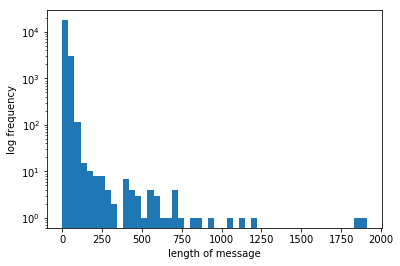

Number of short messages: 20942
Number of long messages: 102
The weather forecast indicates that rains should go on until at least late December. The severe drought parching east Africa has left 10 million facing hunger and the scope of one of the world's worst unfolding humanitarian disasters conjured up memories of Ethiopia's devastating 1984 famine. Seismologists agree that Padang will face more earthquakes in future, and warn that a much larger quake with far greater destructive force is inevitable in the region. The flash floods that followed torrential monsoonal rains in north-west Pakistan between 28 and 30 July have caused great loss of life and wide-spread damage to infrastructure, livestock and property in more than 100 villages. Lesotho and Swaziland would also experience scattered rains, he noted. But while floodwaters have subsided in some areas, there has been fresh flooding in the north of the state and more heavy rainfall forecast elsewhere. Approximately 1.9 million pe

In [9]:
# How long are the messages in our training set? 
message_lengths = []
# Use a for loop over X_train to fill up message_lengths
### YOUR CODE BEGINS HERE ###
for msg in X_train:
  message_lengths.append(len(word_tokenize(msg)))
### YOUR CODE ENDS HERE ###

# Visualize the message lengths using a histogram
plt.hist(message_lengths, bins=50, log=True)
plt.xlabel("length of message")
plt.ylabel("log frequency")
plt.show()

# Compare short versus long messages
print("Number of short messages: %s" 
      % np.count_nonzero(np.array(message_lengths) < 100))
print("Number of long messages: %s" 
      % np.count_nonzero(np.array(message_lengths) > 100))


for i in message_lengths:
  if i > 1750:
    print(X_train[message_lengths.index(i)])
    

Now, we will look at some example messages in each label. 

An index is the location of an element in a list or array. The following cell uses `np.where` to find indices where `y_train` is 0 or 1, randomly samples 5 indices, and prints out the messages in `X_train` at those indices.  

In [10]:
# Feel free to rerun this cell multiple times to look at more messages
print("Messages related to aid:\n")
for idx in random.sample(list(np.where(y_train == 1)[0]), 5): 
  print(y_train[idx], X_train[idx])
print("\n-------------------\n")
print("Messages not related to aid:\n")
for idx in random.sample(list(np.where(y_train == 0)[0]), 5): 
  print(y_train[idx], X_train[idx])

Messages related to aid:

1 Tarpaulin sheets will also be distributed to cover temporary shelters and make them fully waterproofed.
1 *By Katarina Hije* BAMAKO, 30 April 2015 (IRIN) - The last few years in Mali have been busy: an independence declaration, a coup, a mutiny, a northern takeover by Islamist groups, a French military intervention, a hostage crisis, a guerrilla campaign, a preliminary peace deal, and finally, in February, a ceasefire.
1 All donated items will be delivered to Myanmar via the Friendship Bridge.
1 Dubai (dpa) - A major telethon hosted by the Dubai-based Al-Arabiya channel in association with Saudi television has raised 32 million dollars for the victims of the massive earthquake in Pakistan, the Saudi Press Agency reported Sunday.
1 The Garisa-Dadab road in Kenya is closed to traffic due to high incidents of banditry, but for Garisa based operations, all convoys must have a prior security clearance and accompanied by one escort vehicle.

-------------------

M

## Baseline

As a reminder, our goal is to use the examples in the training data to create a model that will predict whether or not a given message is related to aid.

It is good practice to establish a baseline to compare our models against. An example of a simple baseline for this task would be a classifier that predicts the majority class. 

**Q**: Pretend you are living in a drought. Would this baseline be a good classifier for predicting rain each day? 

We saw above that the most common class in our dataset are messages that are not aid related. So, this baseline would predict a label of 0 for every message. 

To implement this, we will use `np.zeros(n)`, where `n` is the length of the resulting zero vector. 

In [11]:
# Example of np.zeros()
print(np.zeros(5))
print(np.zeros(10))

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
# Assign y_train_pred and y_val_pred to your predicted y labels 
# for the train and validation data sets, respectively
### YOUR CODE BEGINS HERE ###
y_train_pred = np.zeros(y_train.shape[0])
y_val_pred = np.zeros(y_val.shape[0])
### YOUR CODE ENDS HERE ###

## Evaluation

To judge how good a model is, we have two **evaluation** metrics: accuracy and F1. 

**Accuracy** is the number of correct predictions performed by our model, divided by the number of total predictions. 

In [0]:
def calculate_accuracy(y_true, y_pred): 
  # Calculate accuracy of the baseline using a for loop
  # HINT: accuracy = correct/total
  ### YOUR CODE BEGINS HERE ###
  correct = 0
  index = 0
  for i in y_true:
    if y_true[index] == y_pred[index]:
      correct += 1
    index += 1
  return correct/y_true.shape[0]
      
  ### YOUR CODE ENDS HERE ###

In [14]:
# Calculate and print the accuracy of this baseline
# on the train and val data sets 
# using the function you wrote above
### YOUR CODE BEGINS HERE ###
print("The accuracy is {:.2f}%".format(calculate_accuracy(y_train, y_train_pred)*100))
print("The accuracy is {:.2f}%".format(calculate_accuracy(y_val, y_val_pred)*100))
### YOUR CODE ENDS HERE ###

The accuracy is 58.73%
The accuracy is 59.27%


Note: A lot of calculations on arrays and matrices that can be done in a for loop can be **vectorized** using NumPy. Vectorization is faster and used all the time by AI researchers. 

In [15]:
# Calculate and print the accuracy of the baseline
# on the train and val sets using NumPy functions 
print("Training accuracy:", np.count_nonzero(y_train==y_train_pred)/y_train.shape[0])
print("Validation accuracy:", np.count_nonzero(y_val==y_val_pred)/y_val.shape[0])

Training accuracy: 0.5873325097405683
Validation accuracy: 0.5926933540614069


If a dataset is unbalanced, which means there are different numbers of examples for each class, it is often useful to report the **F1 score**. 

First let's review the different kinds of errors and correct predictions we can make. 

|   	|   Actual: Yes	| Actual: No   	|  
|---	|---	|---	|
| **Predicted: Yes**  	|  True Positive (TP) 	|  False Positive (FP) | 
| **Predicted: No**  	| False Negative (FN)	| True Negative (TN)	| 

These values help us compute precision and recall. 

$$Precision = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

$$ Recall = \frac{\text{TP}}{\text{TP} + \text{FN}}$$ 

For our task, we have the following "plain English" definitions: 
- True Positive: a tweet is related to aid, and we predict it is. 
- False Positive: a tweet isn't related to aid, and we predict it is. 
- False Negative: a tweet is related to aid, and we predict it isn't. 
- True Negative: a tweet is not related to aid, and we predict it isn't. 
- Precision: Of all tweets we predicted as related to aid, how many are actually aid-related? 
- Recall: Of all tweets labeled as related to aid, how many were we able to detect? 

The F1 score combines precision and recall, and is defined as follows: 

$$F1 = \frac{2(Precision)(Recall)}{Precision + Recall}$$

For our baseline, the F1 score is undefined (!) because the number of true positives and false positives is zero and precision cannot be calculated. 

In [0]:
def calculate_F1(y_true, y_pred): 
  '''
  A function for calculating F1
  Start by computing TP, FP, and FN, 
  then precision and recall. 
  @inputs: 
    - y_pred: numpy array of predicted labels
    - y_true: numpy array of actual labels
  '''
  true_positives = 0
  false_positives = 0
  false_negatives = 0
  ### YOUR CODE BEGINS HERE ###
  for i in range(y_true.shape[0]):
    if y_true[i] == 1:
      if y_pred[i] == 1:
        true_positives += 1
      elif y_pred[i] == 0:
        false_negatives += 1
    elif y_true[i] == 0:
      if y_pred[i] == 1:
        false_positives += 1
  
  precision = true_positives / (true_positives + false_positives)
  recall = true_positives / (true_positives + false_negatives)
  
  f1 = (2*precision*recall)/(precision+recall)
  ### YOUR CODE ENDS HERE ###
  return f1

def test_calculate_F1(): 
  '''
  Compares our implementation with sklearn's.
  '''
  y_pred = np.array([1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1])
  y_true = np.array([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1])
  assert calculate_F1(y_true, y_pred) ==  f1_score(y_true, y_pred)
  
  y_pred = np.array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1])
  y_true = np.array([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1])
  assert calculate_F1(y_true, y_pred) ==  f1_score(y_true, y_pred)
  
# If this runs without errors then you're all good!
test_calculate_F1()

## Logistic Regression

Now let's move onto some more sophisticated models. 

As you may have learned earlier this week, logistic regression is a type of classifier that can handle categorical outputs. (Linear regression, on the other hand, can be used to predict continuous outputs, e.g. float numbers.)

For example, you could use logistic regression to predict whether it will rain or not tomorrow, but you would use linear regression to predict the actual amount of rain in inches. 

Our prediction task is binary, so there are only two categories of outcomes. So, we can use logistic regression for our task. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/640px-Logistic-curve.svg.png?1565220409285" alt="Standard Logistic Function" width="400"/>

(The plot above is of a standard logistic function, or a "generic" version of the function used in logistic regression. You don't need to understand it completely, but knowing it makes a curvy shape that allows the top half to be categorized as one class and another half to be the other class is enough. )

Logistic regression predicts the following:

$$\hat{y} = \frac{1}{1 + e^{-(w_1x + w_2)}},$$

where $w_1$ and $w_2$ are weights (which we need to figure out), $x$ is our input, and $\hat{y}$ is the prediction. 

Our input is each message, but for a computer to "read" it, we need to transform the message of words into numbers. 

One way to do this is to represent each message as a vector of word counts. We'll use a `CountVectorizer` to do this. After vectorizing, each row of the input matrix corresponds to a message, each column corresponds to a word, and each entry corresponds to the number of times that message contained that word. 

In [17]:
# Example of CountVectorizer on a toy dataset
Z = ['I like cats', 'I like dogs', 'Dogs like cats'] 
vectorizer = CountVectorizer(max_features=3)
vectorizer.fit(Z)
Z_matrix = vectorizer.transform(Z)
print(vectorizer.get_feature_names())
print(Z_matrix.todense())

['cats', 'dogs', 'like']
[[1 0 1]
 [0 1 1]
 [1 1 1]]


Now, time to write up some code! 

Note that we limit the number of words in our vectorizer to the top 2000 most common ones so that # of features < # of training examples. It is good practice to have fewer features than examples due to the [curse of dimensionality](https://medium.com/diogo-menezes-borges/give-me-the-antidote-for-the-curse-of-dimensionality-b14bce4bf4d2). 

In the code below, you will \\
(a) fit a vectorizer to the training data, \\
(b) use that vectorizer to transform the training and validation data, \\
(c) fit a logistic regression model to the transformed training data, \\
(d) make predictions using the logistic regression model, \\
(e) and check the accuracy of your model on the training and validation data.

Note that a `LogisticRegression` object has the function `fit(X, y)` to train the model, and the function `predict(X)` to output the predicted labels. You will use these functions in the code below.

In [0]:
def run_log_reg(): 
    print("Getting data...")
    # Use the get_data function to get 
    # X_train, y_train, X_val, and y_val
    ### YOUR CODE BEGINS HERE ###
    X_train, y_train = get_data(path + 'disaster_training.csv')
    X_val, y_val = get_data(path + 'disaster_validation.csv')
    X_test, y_test = get_data(path + 'disaster_test.csv')
    ### YOUR CODE ENDS HERE ###
    
    print("Vectorizing...")
    # Initialize CountVectorizer with max_features=2000
    # Fit vectorizer onto X_train
    # Transform X_train and X_val using that vectorizer
    
    ### YOUR CODE BEGINS HERE ###
    vectorizer = CountVectorizer(max_features = 1850)
    vectorizer.fit(X_train)
    X_train = vectorizer.transform(X_train)
    X_val = vectorizer.transform(X_val)
    ### YOUR CODE ENDS HERE ###
    
    print("Size of X_train and y_train after vectorizing:", 
          X_train.shape, y_train.shape)
    print("Size of X_val and y_val after vectorizing:", 
          X_val.shape, y_val.shape) 
    print("Fitting model...")
    model1 = LogisticRegression(random_state=0, solver='liblinear')
    # Fit LogisticRegression model on X_train and y_train
    # Predict on X_train and X_val to get y_train_pred and y_val_pred
    ### YOUR CODE BEGINS HERE ###
    model1.fit(X_train, y_train)
    y_train_pred = model1.predict(X_train)
    y_val_pred = model1.predict(X_val)
    ### YOUR CODE ENDS HERE ###
    print("Training accuracy:", accuracy_score(y_train, y_train_pred))
    print("Training F1:", f1_score(y_train, y_train_pred))
    print("Validation accuracy:", accuracy_score(y_val, y_val_pred)) 
    print("Validation F1:", f1_score(y_val, y_val_pred)) 
    
    return model1, vectorizer.get_feature_names()

In [19]:
model1, vocab = run_log_reg()

Getting data...
Vectorizing...
Size of X_train and y_train after vectorizing: (21046, 1850) (21046,)
Size of X_val and y_val after vectorizing: (2573, 1850) (2573,)
Fitting model...
Training accuracy: 0.8164971966169343
Training F1: 0.7631546669937447
Validation accuracy: 0.7668091721725612
Validation F1: 0.696969696969697


**Q**: Did this logistic regression model perform better or worse than our baseline model?

One of the useful aspects of logistic regression is you can look at the coefficients, or learned weights, to understand the effect that the given feature (or word) had on the overall prediction. 

**Q**: What do you notice about the words that distinguish the two classes of messages? 

In [20]:
# Look at coefficients! 
coefficients = model1.coef_[0]
indices = np.argsort(coefficients) # sort low->high
# Most negatively weighted
print("Not related to aid")
for i in indices[:20]:
  print(vocab[i], coefficients[i])
print()
# Most positively weighted
print("Related to aid")
for i in indices[-20:]: 
  print(vocab[i], coefficients[i])

Not related to aid
incomplete -2.064746941520863
showers -1.812309441644281
stations -1.703213273377864
southwest -1.5650078293419165
job -1.498148121127859
2013 -1.470235341749554
milk -1.4084807031981599
cans -1.3967699726400513
passport -1.3154936970214808
enable -1.2934244739622685
visa -1.2886612508241662
met -1.2863970925448396
preparation -1.2848980385506572
jesus -1.1897530148689177
indonesian -1.1875767140029738
spent -1.1745079319474887
prices -1.1680654311314302
religious -1.1668296668189426
traditional -1.1663135550704822
availability -1.1620274392778835

Related to aid
victims 1.4721226818562687
death 1.4960229585746436
missing 1.5101214856749174
hunger 1.5304499296861755
dying 1.5474682465116443
killing 1.5726370362989706
targeted 1.5791428031557617
donation 1.6093926275878843
tents 1.6254686000097756
shelter 1.6470200300750812
donate 1.6742473498500372
survivors 1.6824817737401738
dead 1.7018421783820519
tent 1.703748699058197
terrorist 1.7791864826808852
trapped 1.82403

## Neural Networks

Now, time to play around with even bigger models! 

**Deep learning** is one of the most popular areas of AI right now. A neural network trains on a dataset and updates its weights using backpropagation. You can think of backpropagation as a downstream of error messages, telling the neural network to make small adjustments to perform better in the next iteration. After training, a neural network uses its weights to predict on new data. 

You can combine multiple neurons together into layers, where the outputs of one layer feed into the next one. 

To implement neural networks we will use a Python library called Keras. 

I tend to think of Keras as a box of legos, and the different size legos and colors correspond to different kinds of neural network layers we can put together. 

In [21]:
# import
from keras import backend as K
import tensorflow as tf
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0816 14:59:34.214594 139953364948864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0816 14:59:34.216333 139953364948864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0816 14:59:34.217515 139953364948864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0816 14:59:35.495695 139953364948864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [0]:
# more imports
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, CuDNNLSTM, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2

Before we create any model, we need to wrangle our message data into the correct input format. 

First, we need to map each word to some unique integer value. This will allow us to represent each message as a vector of these integers. 

Below is an example using a toy dataset. 

In [23]:
# Example of using a Keras Tokenizer 
Z = ['I like cats and dogs', 'I like dogs', 'Dogs like cats'] 
tokenizer = Tokenizer()

# fit the tokenizer to Z
tokenizer.fit_on_texts(Z)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size:", vocab_size)

# map the words to integers
Z_seq = tokenizer.texts_to_sequences(Z)
print(Z_seq)

Vocab size: 6
[[3, 1, 4, 5, 2], [3, 1, 2], [2, 1, 4]]


Then, we want to pad all sequences to the same length. This means all sequences are the same size, and sequences that are short end in zeros. For our toy dataset `Z`, we choose a `maxlen` of 5. 

In [24]:
Z_pad = pad_sequences(Z_seq, maxlen=5, padding='post')
print(Z_pad)

[[3 1 4 5 2]
 [3 1 2 0 0]
 [2 1 4 0 0]]


Finish the following function so that it uses a `Tokenizer` fit on `X_train` to convert `X_train`, `X_val`, and `X_test` to padded integer sequences. We choose a maximum length of 100 because as we saw during our data exploration stage, most messages are under 100 tokens long. 

In [0]:
def preprocess_data(X_train, X_val, X_test): 
  '''
  @inputs
    - X_train, X_val, X_test: Numpy arrays of messages (strings)
  @outputs
    - X_train_pad, X_val_pad, X_test_pad: Numpy matrices of integers
    
  '''
  max_length = 100
  ### YOUR CODE BEGINS HERE ###
  # 1. Fit a Tokenizer on X_train
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(X_train)
  
  # 2. Map the words in X_train, X_val, and X_test to integers
  X_train_seq = tokenizer.texts_to_sequences(X_train)
  X_val_seq = tokenizer.texts_to_sequences(X_val)
  X_test_seq = tokenizer.texts_to_sequences(X_test)
  
  # 3. Pad documents to max length
  X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
  X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')
  X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')
  
  ### YOUR CODE ENDS HERE ###
  return X_train_pad, X_val_pad, X_test_pad, tokenizer


### Simple Neural Network

Our first neural network model will take in an input, pass it through the weights of an embedding layer, flatten it, send it through the weights of a hidden layer of size 5, and then send it through the weights of an output layer of size 1. The embedding layer has size 100 and is randomly initialized. We use a ReLU activation function for the hidden layer, and sigmoid activation function for the output layer. 

A dense layer is fully connected layer, so if we diagrammed it out, there are arrows from all the nodes in the previous layer to the next layer. 

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/320px-Colored_neural_network.svg.png?1565325022586)

Here are the building blocks to know about: 
- `Embedding()`, which has parameters `vocab_size`, `embed_size`, and `input_length`. In our case, we should set `input_length=max_length`. 
- `Flatten()`
- `Dense()`, whose first parameter is 5 and `activation='relu'`.
- `Dense()`, whose first parameter is 1 and `activation='sigmoid'`. 

You can use `model.add()` to add each of these layers to your model. For example, `model.add(Flatten())`.

A [diagram](https://drive.google.com/file/d/1yAoMn3OppN7sW3CZDziaIrFaVuo09eto/view?usp=sharing) of our model is below. 

![alt text](https://i.imgur.com/uAvKDS0.png)

In [26]:
np.random.seed(42)
random.seed(42)
tf.set_random_seed(1234)

def simple_nn(vocab_size, embed_size, max_length): 
  model = Sequential()
  ### YOUR CODE BEGINS HERE ###
  model.add(Embedding(vocab_size, embed_size, input_length=max_length))
  model.add(Flatten())
  model.add(Dense(5, activation="relu"))
  model.add(Dense(1, activation="sigmoid"))
  ### YOUR CODE ENDS HERE ###
  model.compile(optimizer='adam', loss='binary_crossentropy', 
                metrics=['acc'])
  print(model.summary())
  return model

# get data
X_train, y_train = get_data(path + 'disaster_training.csv')
X_val, y_val = get_data(path + 'disaster_validation.csv')
X_test, y_test = get_data(path + 'disaster_test.csv')

# preprocess data (words --> integers)
X_train_pad, X_val_pad, X_test_pad, tokenizer = preprocess_data(X_train, X_val, X_test)
vocab_size = len(tokenizer.word_index) + 1

# create and train the simple neural network model
model2 = simple_nn(vocab_size, 100, X_train_pad.shape[1])
model2.fit(X_train_pad, y_train, epochs=30, verbose=1)

# evaluate the model predictions
y_train_pred = model2.predict(X_train_pad)
y_train_pred = (y_train_pred > 0.5).astype(int).flatten()
print('Training Accuracy: %f' % (accuracy_score(y_train, y_train_pred)))
print('Training F1: %f' % (f1_score(y_train, y_train_pred)))
y_val_pred = model2.predict(X_val_pad)
y_val_pred = (y_val_pred > 0.5).astype(int).flatten()
print('Validation Accuracy: %f' % (accuracy_score(y_val, y_val_pred)))
print('Validation F1: %f' % (f1_score(y_val, y_val_pred)))

W0816 14:59:37.290610 139953364948864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0816 14:59:37.342186 139953364948864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0816 14:59:37.367655 139953364948864 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          3214600   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 50005     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 3,264,611
Trainable params: 3,264,611
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
21046/21046 [==============================] - 6s 294us/step - loss: 0.6458 - acc: 0.6601
Epoch 2/30
21046/21046 [==============================] - 4s 170us/step - loss: 0.4813 - acc: 0.8156
Epoch 3/30
21046/21046 [==============================] -

We didn't do too bad! It seems like we're **overfitting** a lot to our training data set, though. 

**Q**: What is overfitting? (Hint: see the plot below.)

![alt text](https://upload.wikimedia.org/wikipedia/commons/6/68/Overfitted_Data.png)

Our neural network does have a lot of trainable weights, which suggests our model is may be too complex for the number of examples we have. 

### Simple NN w/ GloVe

We saw that in our previous model, our embeddings for each word were randomly initialized (as a layer of the neural network) and trained along with the rest of the model. 

Instead of starting with random embeddings and having to learn them, we can instead start with word embeddings that have already been pretrained on some other large corpus of data. Such embeddings are used all the time in NLP.

For the embeddings in the model below, we will use 100-dimensional GloVe vectors that have already been trained on Wikipedia and news data. 

In [0]:
def get_embeddings(): 
  embeddings = {}
  with open('/content/drive/My Drive/Berkeley AI4ALL/glove.twitter.27B.100d.txt', 
            'r') as glovefile: 
    for line in glovefile:
      values = line.split(' ')
      word = values[0]
      values = np.asarray(values[1:], dtype='float32')
      embeddings[word] = values
  return embeddings

In [28]:
embeddings = get_embeddings()
print(embeddings['cat'])

[ 0.38446   -0.45507    0.45351    0.4301    -0.050908  -0.26414
  0.43253   -0.3166     0.32214    0.0064333 -0.47066    0.95335
 -3.2063     0.010913  -0.27565    1.1732     0.52033   -0.045973
  0.094254  -0.53846    0.0035668  0.11934   -0.17815   -0.58093
  0.65081   -0.48746   -0.50961    0.42771   -0.30638    0.32385
  0.33687   -0.1717    -0.39104   -0.19038    0.37016   -0.50396
  0.041969  -0.20517    0.3223     0.41217   -0.42191   -0.26359
 -0.1773    -0.35658    0.52145    0.57282    0.60204    0.74369
  0.33377   -0.45041    0.015978  -0.12575    0.29786   -0.77635
  0.23759    0.63821    0.63726    1.0079     0.13714   -0.031928
 -0.21299    0.52348    0.67934   -0.1427    -0.64236   -0.47996
 -0.87915    0.17501    0.64517    0.3778     0.53493   -0.29723
 -0.25206   -0.757      0.33647    0.053759  -0.8084     0.22205
  0.10799   -0.68982    1.5073     0.96641   -0.51839    0.32803
  0.11878   -0.72009    0.23227    0.098733  -0.096396   0.40295
 -0.003925  -0.10405   

Each vector encodes the meaning of a word. The values in each vector are learned based on the context that surrounds a word each time it occurred in the training corpus. 

For example, we can estimate how similar two words are in meaning by computing the cosine distance between their corresponding embedding vectors: 

In [29]:
# 'cat' and 'dog' have a smaller distance and are closer together
# in meaning than 'cat' and 'chair'
# Feel free to compute cosine distance for other pairs of words 
print(cosine(embeddings['cat'], embeddings['dog']))
print(cosine(embeddings['cat'], embeddings['chair']))

0.1247909665107727
0.511318564414978


[Here](http://projector.tensorflow.org/) is a cool interactive visualization of another type of word embedding, called word2vec, which works in a similar manner as GloVe. 

We can compute the nearest neighbors of different GloVe words as well, to see that closer words are more closely related.

In [30]:
# Feel free to try other words as well 
word = 'girl'

# find the word
vocab = sorted(embeddings.keys())
idx = vocab.index(word)

# get the embeddings of every other word
m = []
for word in vocab: 
  m.append(embeddings[word])
m = np.array(m)

# compute similarity between embeddings of the word and all other words
sim_m = cosine_similarity(m, [m[idx]])

# show the top 10 closest words to the given word
ranking = np.argsort(sim_m, axis=0)
for j in range(2, 12): # skip 1 because it's itself
  print(vocab[ranking[-j][0]])

boy
girls
she
friend
guy
chick
like
sister
boyfriend
bitch


We saw above that words with similar semantic relationships to each other are mapped into the embedding space in similar ways. 

<img src="https://nlp.stanford.edu/projects/glove/images/comparative_superlative.jpg" alt="Glove Word Analogies" width="600"/>

Word embeddings can also be used to compute analogies using arithmetic. Our embeddings are only 100-dimensional so they don't perform too great on some classic analogies (e.g. king - man + queen yields royal instead of woman), but they still do pretty well on cities & capitals, as we will see next.

In [31]:
analogies = [('china', 'beijing', 'paris'), 
             ('germany', 'berlin', 'london'), 
             ('stronger', 'strongest', 'softer'), 
             ('king', 'man', 'queen')
            ]
for analogy in analogies: 
  result = embeddings[analogy[0]] - embeddings[analogy[1]] + embeddings[analogy[2]]
  
  # calculate similarity between our 'result' and
  # m, which has the embeddings of all words in the vocab
  sim_m = cosine_similarity(m, [result])
  
  # show the closest word to our 'result' that wasn't in the original list
  ranking = np.argsort(sim_m, axis=0)
  for j in range(1, 5): # skip 1 because it's itself
    w = vocab[ranking[-j][0]]
    if w not in analogy: 
      print(analogy, w)
      break

('china', 'beijing', 'paris') france
('germany', 'berlin', 'london') england
('stronger', 'strongest', 'softer') smoother
('king', 'man', 'queen') royal


Now, we'll modify the `Embedding` layer of our simple neural network to include GloVe vectors. This layer needs to take in an `embedding_matrix` so it knows how to look up the GloVe vectors for each word. 

In [0]:
def get_embedding_matrix(embeddings, vocab_size, embed_size, tokenizer): 
  '''
  Defines a matrix where each row corresponds
  to a word's GloVe vector. 
  The rows are in the same order as the word->integer
  mapping in our tokenizer. ]
  @inputs
  - embeddings: a dictionary from a word (string) to a vector
  - vocab_size: int
  - embed_size: int, same size as # of elements in GloVe vector
  - tokenizer: Tokenizer from preprocess_data()
  '''
  
  embedding_matrix = np.zeros((vocab_size, embed_size))
  # for each word from the tokenizer, get its corresponding embedding
  for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
      
  # return embeddings of all words from the tokenizer
  return embedding_matrix

Now, we want to write code in `simple_glove_nn()` that is the same as `simple_nn()` except the `Embedding` layer will now have more parameters. To the embedding layer, you'll want to add the parameters `weights=[embedding_matrix]` and `trainable=True`. This will use the embedding matrix to map our words into vectors, and still allow those weights to be further trained on the given data. 

Note that this differs from our first simple neural network because the embedding weights are now starting from a pretrained embedding, rather than starting from random weights.

In [33]:
np.random.seed(42)
random.seed(42)
tf.set_random_seed(1234)

def simple_glove_nn(vocab_size, embed_size, max_length, embedding_matrix): 
  model = Sequential()
  ### YOUR CODE BEGINS HERE ###
  model.add(Embedding(vocab_size, embed_size, input_length=max_length, weights=[embedding_matrix], trainable=True))
  model.add(Flatten())
  model.add(Dense(5, activation="relu"))
  model.add(Dense(1, activation="sigmoid"))
  ### YOUR CODE ENDS HERE ###
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  print(model.summary())
  return model 

X_train, y_train = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_training.csv')
X_val, y_val = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_validation.csv')
X_test, y_test = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_test.csv')
X_train_pad, X_val_pad, X_test_pad, tokenizer = preprocess_data(X_train, 
                                                                 X_val, X_test)
vocab_size = len(tokenizer.word_index) + 1
embed_size = 100
embeddings = get_embeddings()
embedding_matrix = get_embedding_matrix(embeddings, vocab_size, 
                                        embed_size, tokenizer)
model3 = simple_glove_nn(vocab_size, embed_size, X_train_pad.shape[1], embedding_matrix)
model3.fit(X_train_pad, y_train, epochs=30, verbose=1)

y_train_pred = model3.predict(X_train_pad)
y_train_pred = (y_train_pred > 0.5).astype(int).flatten()
print('Training Accuracy: %f' % (accuracy_score(y_train, y_train_pred)))
print('Training F1: %f' % (f1_score(y_train, y_train_pred)))
y_val_pred = model3.predict(X_val_pad)
y_val_pred = (y_val_pred > 0.5).astype(int).flatten()
print('Validation Accuracy: %f' % (accuracy_score(y_val, y_val_pred)))
print('Validation F1: %f' % (f1_score(y_val, y_val_pred)))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          3214600   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 50005     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 3,264,611
Trainable params: 3,264,611
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
21046/21046 [==============================] - 4s 186us/step - loss: 0.6377 - acc: 0.6807
Epoch 2/30
21046/21046 [==============================] - 4s 170us/step - loss: 0.4970 - acc: 0.8050
Epoch 3/30
21046/21046 [==============================] -

Surprisingly, we don't see too much of an improvement, even by using pre-trained word embeddings. Still, pre-trained word embeddings are commonly used in NLP, and so we'd like them to be an option for you to later include in your custom neural network (near the end of this notebook). 

### LSTM w/ GloVe

Now we will use a more complex model. 

A recurrent neural network (RNN) looks like the following when unrolled: 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/800px-Recurrent_neural_network_unfold.svg.png" alt="RNN" width="600"/> 

Here, $x_{t}$ is a token in our dataset, and $h_{t}$ are hidden states, and $o_{t}$ are outputs. For our problem, instead of an output at every time step (at every word), we will have a single output at the last RNN layer (after seeing every word). 

Our hidden cells are called LSTMs (long short-term memory). 

This is what an LSTM looks like (think of it as one of the blue $h_t$ rectangles in the illustration above). 

<img src="https://upload.wikimedia.org/wikipedia/commons/3/3b/The_LSTM_cell.png" alt="LSTM Cell" width="300"/>

You don't have to worry about understanding all of the arrows and components, but the main idea is that there are multiple calculations involved in an LSTM. These calculations correspond to things like forgetting, manipulating, or sending forward certain parts of the incoming information. 

[This](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a really good blog post about LSTMs if you want to do further reading. 

In this section, you will put together a neural model that we designed to help prep you to create your own model in the next section. Instead of using Keras's standard `LSTM` layer, we will use `CuDNNLSTM` which is an implementation that runs faster on a GPU. 

We also introduce a new concept called **regularization**, which is a technique for reducing overfitting. We'll specifically use dropout. 

With dropout, randomly selected inputs are ignored. This makes our model more flexible, and it's sort of like training multiple "thinner" neural networks at the same time. Keras makes it so that dropout only occurs during training, not during predicting. 

A [diagram](https://drive.google.com/file/d/1YJoZLbYqfKaMDPf6peRf58BizIueBSU3/view?usp=sharing) of our model is below. (Note that our sequences are actually 100 tokens long, but this toy diagram pretends it's 4 tokens long.)

<img src="https://i.imgur.com/l1HOV5r.png" alt="Stacked LSTM with Embeddings" width="400"/>

This neural network will have the following components: 
* `Embedding` layer the same as our simple NN w/ GloVe, except `trainable=False`. This means the embedding layer doesn't change when our model learns. We found that this makes the network perform better. 
* `CuDNNLSTM` layer of size 10, and `return_sequences=True`. We want to return sequences so we can stack another LSTM on top of this one. 
* `CuDNNLSTM` layer of size 50, and `return_sequences=True`.
* `Dropout` with `rate=0.2`. We are essentially setting 20% of inputs to zero. 
* `CuDNNLSTM` layer of size 20. 
* `Dense` layer of size 1 with a sigmoid activation function. 

While this model is training, you can look at the Fun Resources section at the bottom of this notebook. This model should take about 20 minutes to train. You can also start brainstorming your custom model. 

In [34]:
np.random.seed(42)
random.seed(42)
tf.set_random_seed(1234)

def lstm_glove(vocab_size, embed_size, max_length, embedding_matrix): 
  model = Sequential()
  ### YOUR CODE BEGINS HERE ###
  model.add(Embedding(vocab_size, embed_size, input_length=max_length, weights=[embedding_matrix], trainable=False))
  model.add(CuDNNLSTM(10, return_sequences=True))
  model.add(CuDNNLSTM(50, return_sequences=True))
  model.add(Dropout(rate=0.2))
  model.add(CuDNNLSTM(20))
  model.add(Dense(1, activation = "sigmoid"))
  ### YOUR CODE ENDS HERE ###
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  print(model.summary())
  return model

X_train, y_train = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_training.csv')
X_val, y_val = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_validation.csv')
X_test, y_test = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_test.csv')
X_train_pad, X_val_pad, X_test_pad, tokenizer = preprocess_data(X_train,X_val, X_test)
vocab_size = len(tokenizer.word_index) + 1
embed_size = 100
embeddings = get_embeddings()
embedding_matrix = get_embedding_matrix(embeddings, vocab_size, embed_size, tokenizer)
model4 = lstm_glove(vocab_size, embed_size, X_train_pad.shape[1], embedding_matrix)
model4.fit(X_train_pad, y_train, epochs=30, verbose=1)

y_train_pred = model4.predict(X_train_pad)
y_train_pred = (y_train_pred > 0.5).astype(int).flatten()
print('Training Accuracy: %f' % (accuracy_score(y_train, y_train_pred)))
print('Training F1: %f' % (f1_score(y_train, y_train_pred)))
y_val_pred = model4.predict(X_val_pad)
y_val_pred = (y_val_pred > 0.5).astype(int).flatten()
print('Validation Accuracy: %f' % (accuracy_score(y_val, y_val_pred)))
print('Validation F1: %f' % (f1_score(y_val, y_val_pred)))

W0816 15:05:13.306663 139953364948864 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          3214600   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100, 10)           4480      
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 100, 50)           12400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 20)                5760      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 3,237,261
Trainable params: 22,661
Non-trainable params: 3,214,600
_____________________________________________________________

KeyboardInterrupt: ignored

### Your Own NN!

Here you'll build your own neural network for our classification task. 

Recall the different building blocks we've given you in previous models: 
* The `Embedding` layer, which can include GloVe or be random. If you use GloVe, you can set this to be trainable or not trainable. 
* `Flatten`, which is used if you want to input your embedding layer or any LSTM sequence layers into a dense layer. 
* `Dense`, which is just a regular densely-connected neural network layer. We've seen dense layers of size 5 and 1, but you can set this value to whatever you what. Remember to add a dense layer of size 1 with a sigmoid activation function at the end. 
* `CuDNNLSTM`, which is an LSTM. You can stack these by returning sequences. We've seen examples of LSTMs of size 20 and 50. You can set the dimensionality of the output to whatever you want. 

Now, note that when we say "whatever you want," you should keep in mind that the larger your model, the longer it will take to train. Also, Colaboratory doesn't have infinite resources, so you may end up crashing the notebook if you try to make it do too much. We recommend playing around with values between 0 and 100 for now. 

When you modify these hyperparameters such as the size of each layer, you're performing what is known as **hyperparameter tuning**. Make sure you write down the values you get with different versions of your model so you can figure out which set of hyperparameters yields the best model you can come up with. 

*   If your training accuracy is much higher than your test accuracy, try making your model smaller (e.g. fewer units in each LSTM layer or fewer LSTM layers) or adding dropout regularization.
*   If your training accuracy and test accuracy are similar, try making your model bigger. 

<img src="https://miro.medium.com/max/700/1*WyncMcJhXa7yPYebXyRq-Q.png" alt="error and model" width="400"/> 

In practice, AI researchers may use random search for finding the best hyperparameters for their models. We won't have time to search over many different sets of hyperparameters, but hopefully trying one or two different models is enough to give you a taste of the process. 

In [0]:
X_train, y_train = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_training.csv')
X_val, y_val = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_validation.csv')
X_test, y_test = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_test.csv')
X_train_pad, X_val_pad, X_test_pad, tokenizer = preprocess_data(X_train, 
                                                                 X_val, X_test)
vocab_size = len(tokenizer.word_index) + 1
embed_size = 100
embeddings = get_embeddings()
embedding_matrix = get_embedding_matrix(embeddings, vocab_size, 
                                        embed_size, tokenizer)

In [55]:
vocab_size


32146

In [2]:
reg = 0.5e-6
np.random.seed(42)
random.seed(42)
tf.set_random_seed(1234)

def my_custom_model(vocab_size, embed_size, max_length, embedding_matrix): 
  model = Sequential()
  ### YOUR CODE BEGINS HERE ###
  model.add(Embedding(vocab_size, embed_size, input_length=max_length, weights=[embedding_matrix], trainable=False))
  model.add(CuDNNLSTM(90, return_sequences=True, kernel_regularizer=l2(reg), recurrent_regularizer=l2(reg), bias_regularizer=l2(reg)))
  model.add(BatchNormalization())
  model.add(CuDNNLSTM(90, return_sequences=True, kernel_regularizer=l2(reg), recurrent_regularizer=l2(reg), bias_regularizer=l2(reg)))
  model.add(Dropout(rate=0.5))
  model.add(CuDNNLSTM(90, return_sequences=True, kernel_regularizer=l2(reg), recurrent_regularizer=l2(reg), bias_regularizer=l2(reg)))
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.5))
  model.add(CuDNNLSTM(90, return_sequences=True, kernel_regularizer=l2(reg), recurrent_regularizer=l2(reg), bias_regularizer=l2(reg)))
  model.add(BatchNormalization())
  model.add(Dropout(rate=0.5))
  model.add(CuDNNLSTM(90, kernel_regularizer=l2(reg), recurrent_regularizer=l2(reg), bias_regularizer=l2(reg)))
  model.add(BatchNormalization())
  model.add(Dense(10, activation="relu"))
  model.add(Dense(1, activation="sigmoid"))
  ### YOUR CODE ENDS HERE ###
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
  print(model.summary())
  return model


model5 = my_custom_model(vocab_size, embed_size, X_train_pad.shape[1], 
                   embedding_matrix)
model5.fit(X_train_pad, y_train, epochs=30, verbose=1, validation_data=(X_val_pad, y_val), batch_size=16)

y_train_pred = model5.predict(X_train_pad)
y_train_pred = (y_train_pred > 0.5).astype(int).flatten()
print('Training Accuracy: %f' % (accuracy_score(y_train, y_train_pred)))
print('Training F1: %f' % (f1_score(y_train, y_train_pred)))
y_val_pred = model5.predict(X_val_pad)
y_val_pred = (y_val_pred > 0.5).astype(int).flatten()
print('Validation Accuracy: %f' % (accuracy_score(y_val, y_val_pred)))
print('Validation F1: %f' % (f1_score(y_val, y_val_pred)))

NameError: ignored

## Results & Analysis

Now, time to analyze the results we got for the five models we created. 

First, we can compare how we did on the training and validation sets for each. 

In [0]:
def autolabel(rects, ax):
  """
  Attach a text label above each bar in *rects*, displaying its height.
  Copied from the matplotlib tutorial for "Grouped bar chart with labels".
  """
  for rect in rects:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
      
def plot_comparison(training_scores, validation_scores, labels, ylabel): 
  x = np.arange(len(labels))  
  width = 0.35  
  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, training_scores, width, label='Training')
  rects2 = ax.bar(x + width/2, validation_scores, width, label='Validation')
  ax.set_ylabel(ylabel, size=15)
  ax.set_xticks(x)
  ax.set_xticklabels(labels, rotation=30)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.legend()
  autolabel(rects1, ax)
  autolabel(rects2, ax)
  fig.tight_layout()
  plt.show()

labels = ['baseline', 'logistic regression', 'simple NN', 'simple NN w/GloVe', 
          'LSTM w/ GloVe', 'our model']
### YOUR CODE BEGINS HERE ###
# replace these dummy values with your scores in the same order as labels
training_F1 = [1, 2, 3, 4, 5, 6]
training_acc = [6, 7, 8, 9, 10, 11]
validation_F1 = [2, 3, 4, 5, 6, 7]
validation_acc = [6, 5, 4, 3, 2, 1]
### YOUR CODE ENDS HERE ###

plot_comparison(training_F1, validation_F1, labels, 'F1 Score')
plot_comparison(training_acc, validation_acc, labels, 'Accuracy')

In the "real world", AI researchers compete for the best test set score on leaderboards for tasks such as question answering and textual entailment. These researchers develop a model on the training and validation sets, which are released publicly. Then, they submit their model to the leaderboard, which runs their model on a hidden test set and ranks how well they perform against others. Here's some examples: [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/) and [GLUE](https://gluebenchmark.com/leaderboard).

We'll pretend we're submitting a model to a leaderboard of some sort. We'll run our best model, as determined by validation accuracy, on the test set. 

The following code assumes that our pre-designed LSTM w/ GloVe is the best model. However, it could be that your own custom model performs better! If that is the case, you can just swap out `model4` with your `model5`. 

In [0]:
# run our best model on the test set 
X_train, y_train = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_training.csv')
X_val, y_val = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_validation.csv')
X_test, y_test = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_test.csv')
X_train_pad, X_val_pad, X_test_pad, tokenizer = preprocess_data(X_train, 
                                                                 X_val, X_test)
### YOUR CODE BEGINS HERE ###
# predict on X_test_pad to get y_test_pad
### YOUR CODE ENDS HERE ###
y_test_pred = (y_test_pred > 0.5).astype(int).flatten()
print('Validation Accuracy: %f' % (accuracy_score(y_test, y_test_pred)))
print('Validation F1: %f' % (f1_score(y_test, y_test_pred)))

To get an idea of what a neural network has learned, we can visualize hidden layer features. To do this, we cut off our best model right before the Dense layer and predict on the test set to get hidden features. 

Since we can't visualize 20 dimensions very well on a computer screen, we reduce the dimensionality of the hidden features to 2 using [t-SNE](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1). T-SNE attempts to arrange points so that those that are close in high-dimensional space are still close in 2-D, and those that were far are still far. 

The resulting plot below would show the reduced features colored by their true label. 

The goal is for a neural network to separate out the messages with different labels to different areas of space. 

In [0]:
np.random.seed(42)
random.seed(42)
tf.set_random_seed(1234)

def truncate_model(model, vocab_size, embed_size, max_length, embedding_matrix):
    model_short = Sequential()
    ### YOUR CODE BEGINS HERE ###
    # This code should be copied from the code you wrote for 
    # model4 or model5 except you remove the final Dense layer
    ### YOUR CODE ENDS HERE ###
    for i, layer in enumerate(model_short.layers):
        layer.set_weights(model.layers[i].get_weights())
    model_short.compile(optimizer='adam', loss='binary_crossentropy', 
                        metrics=['acc'])
    return model_short

# get data and embeddings
X_train, y_train = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_training.csv')
X_val, y_val = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_validation.csv')
X_test, y_test = get_data('/content/drive/My Drive/Berkeley AI4ALL/disaster_test.csv')
X_train_pad, X_val_pad, X_test_pad, tokenizer = preprocess_data(X_train, 
                                                                 X_val, X_test)
vocab_size = len(tokenizer.word_index) + 1
embed_size = 100
embeddings = get_embeddings()
embedding_matrix = get_embedding_matrix(embeddings, vocab_size, 
                                        embed_size, tokenizer)

# truncate the model, so we can examine the outputs of an earlier layer (i.e. 'features')
### YOUR CODE BEGINS HERE ###
# Change model4 to model5 if your model5 performs better
model_short = truncate_model(model4, vocab_size, embed_size, 
                             X_train_pad.shape[1], embedding_matrix)
### YOUR CODE ENDS HERE ###
features = model_short.predict(X_test_pad)

# We'll just visualize a subset of the data
# by fitting our 'features' with a lower-dimensional representation 
# which we can then plot, to look for trends/patterns
num_points = 1000
tsne = TSNE(n_components=2)
tsne_features = tsne.fit_transform(features[:num_points])
color_dict = {0: "green", 1: "orange"}
colors = []
for label in y_test[:num_points]: 
  colors.append(color_dict[label])
fig, ax = plt.subplots()
plt.scatter(tsne_features[:,0], tsne_features[:,1], 
            c=colors, alpha=0.1)
legend_elements = [Line2D([0], [0], marker='o', color='w', 
                          label='not aid-related',
                          markerfacecolor='green', markersize=15), 
                   Line2D([0], [0], marker='o', color='w', 
                          label='aid-related',
                          markerfacecolor='orange', markersize=15)]
ax.legend(handles=legend_elements)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

We can also look at what kind of mistakes we made. A confusion matrix displays the number of false positives, false negatives, true negatives, and true positives we got with our model. Go back up to the explanation of F1 for a table representing a confusion matrix. Your code for calculating F1 is very similar to the code for calculating the values in a confusion matrix. 

In [0]:
# confusion matrix
def display_confusion_matrix(y_true, y_pred): 
  '''
  A function for calculating F1
  Start by computing TP, FP, and FN, 
  then precision and recall. 
  @inputs: 
    - y_pred: numpy array of predicted labels
    - y_true: numpy array of actual labels
  '''
  true_positives = 0
  false_positives = 0
  false_negatives = 0
  true_negatives = 0
  ### YOUR CODE BEGINS HERE ###
  # calculate each of the matrix values
  ### YOUR CODE ENDS HERE ###
  conf_mat = np.zeros((2, 2))
  conf_mat[0][0] = true_positives
  conf_mat[1][1] = true_negatives
  conf_mat[0][1] = false_positives
  conf_mat[1][0] = false_negatives
  sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, 
              fmt='.1f', yticklabels=[1, 0], xticklabels=[1, 0])
  plt.title('Confusion Matrix for Test Set')
  plt.ylabel('Predicted Value')
  plt.xlabel('Actual Value')
  plt.show()

In [0]:
display_confusion_matrix(y_test, y_test_pred)

In [0]:
# examples of errors
# feel free to run this cell multiple times to see more examples
print("true\tpred\tmessage")
for idx in random.sample(list(np.where(y_test_pred != y_test)[0]), 10): 
  print(y_test[idx], '\t', y_test_pred[idx], '\t', X_test[idx])

**Q**: What do you think are some reasons why our model made these mistakes?  

## Fun Resources 

Good job! You've reached the end of this notebook. 

Here are some fun links for exploring more of NLP/AI.  

*  [Talk To Transformer](https://talktotransformer.com/) - Type stuff and a neural network guesses what comes next
* [Thing Translator](https://thing-translator.appspot.com/) - Take pictures of objects and translate them in different languages (use this with your phone)
* [Allen NLP demos](https://demo.allennlp.org/) - They have a lot of different demos you can try out on the left sidebar 
* [Talk to Books](https://books.google.com/talktobooks/) - Browse books using everyday language
* [Tensorflow Playground](http://playground.tensorflow.org) - Play around with a neural network in your browser
* [Quick, Draw](https://quickdraw.withgoogle.com/) - Contribute doodles to a drawing [dataset](https://quickdraw.withgoogle.com/data). 

Browse the syllabi of NLP classes that college students take! These may be challenging to understand, but it can give you an idea of the possibilities in this field. 

 * Stanford [CS 124](http://web.stanford.edu/class/cs124/) - From Languages to Information

* Berkeley [Info 256](http://people.ischool.berkeley.edu/~dbamman/info256.html) - Applied Natural Language Processing

* University of Washington [CSE 517](https://courses.cs.washington.edu/courses/cse517/19wi/) - Natural Language Processing

